# Bin Packing Problem With Evolutionary Computations

In [16]:
from enum import Enum
from copy import copy, deepcopy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from math import sqrt

## 2D-Bin Packing Baseline - Greed Search

In [17]:
class PointType(Enum):
    BOTTOM_LEFT = 0
    BOTTOM_RIGHT = 1
    TOP_LEFT = 2
    TOP_RIGHT = 3

# Plot settings
figsize = (12,6)
placed_rect_color = 'lightblue'
unplaced_rect_color = 'grey'
ghost_rect_color = 'lightgrey'
edge_color = 'black'
alpha = 0.5

# Time settings
frametime = 0.02
starttime = 1
endtime = 10

all_rects = []
max_width = 0


def argmax(lst):
    return lst.index(max(lst))

def initialize_plot(C, rects = None, frame_time: float = 0.02, start_time: float = 4, end_time: float = 20, fig_size = (12,6)):
    global frametime, starttime, endtime
    global figsize, max_width
    global all_rects

    frametime = frame_time
    starttime = start_time
    endtime = end_time
    figsize = fig_size

    # Used for showing custom rects when late initializing plot
    if rects == None:
        all_rects = copy(C.unpacked_rects)
    else:
        all_rects = rects
    max_width = sum([r[0] for r in all_rects]) + 1 + len(all_rects)#TODO: Find better way of doing this


def plot_configuration(C, last_frame: bool):
    _, axs = plt.subplots(nrows=1, ncols=2,figsize=(12,6))

    # TODO: Find way to set this in init instead of every time plot is updated
    # Set the ticks for the main plot
    axs[0].set_xlim([0,C.size[0]])
    axs[0].set_ylim([0,C.size[1]])
    axs[0].set_xticks(range(0, C.size[0]+1, 5))
    axs[0].set_yticks(range(0, C.size[1]+1, 5))
    
    # Hide ticks for secondary ploty
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_xlim([0,max_width])
    axs[1].set_ylim([0,max_width])


    # Draw the placed rects in main plot
    for rect in C.packed_rects:
        draw_rect(axs[0], rect.origin, rect.width, rect.height, placed_rect_color, edge_color, alpha)
    
    # Draw the possible ccoas main plot
    for rect in C.L:
        draw_rect(axs[0], rect.origin, rect.width, rect.height, ghost_rect_color, edge_color, 0.05)
    
    draw_points(axs[0], C.concave_corners)

    # Draw secondary plot
    draw_rects_overview(axs[1], all_rects, C.unpacked_rects)

    #final_time = endtime if last_frame else 0
    plt.show(block=False)
    #plt.pause(frametime + final_time)
    plt.close()


def draw_points(ax, corners: list[tuple], color='red', marker='x'):
    """
    Plot points given on the format [Point, Pointtype]
    """
    x = [i[0][0] for i in corners]
    y = [i[0][1] for i in corners]
    ax.scatter(x, y, c=color, marker=marker)


def draw_rects_overview(ax, all_rects: list, unplaced_rects: list):
    tallest = 0
    current_pos = (1,1)

    for w,h in all_rects:
        unplaced: bool = ((w,h) or (h,w)) in unplaced_rects
        color = unplaced_rect_color if unplaced else placed_rect_color
        tallest = max(tallest, h)
        
        draw_rect(ax, current_pos, w, h, background_color=color, edge_color=edge_color,alpha=alpha)
     
        current_pos = (current_pos[0] + w + 1, current_pos[1])
        
        if max_width < current_pos[0] + w + 1:
            current_pos = (1, current_pos[1] + tallest + 1)
            tallest = 0


def draw_rect(ax, origin, w, h, background_color, edge_color, alpha):
    box = Rectangle(origin, w, h, fc=background_color,ec=edge_color,alpha=alpha)
    ax.add_patch(box)

In [18]:
class Rect:

    def __init__(self, origin: tuple, width:float, height:float, origin_type: PointType = PointType.BOTTOM_LEFT, rotated:bool = False) -> None:
        """
        A container class and data structure for a rect representing a box to be packed. 
        Main functionality consists of wrapping and data and checking if rects overlap contain points etc.

        Parameters
        ----------
        origin, tuple
            a tuple of (x,y) coordinates containing the ogigin point of the box. Can be either of corners depending on the case

        width, float
            the width of the rect

        height, float
            the height of the rect

        origin_type, PointType
            an enum value determining which of the four corners is the origin point

        rotated, bool
            boolean value indicating whether the rect is rotated
        """        

        assert(0 < width and 0 < height)

        if rotated:
            temp = height
            height = width
            width = temp

        # Shift origin to bottom left corner depending on what type of point was given
        if origin_type == PointType.BOTTOM_LEFT:
            self.origin = origin
        if origin_type == PointType.TOP_LEFT:
            self.origin = (origin[0], origin[1] - height)
        if origin_type == PointType.BOTTOM_RIGHT:
            self.origin = (origin[0] - width, origin[1])
        if origin_type == PointType.TOP_RIGHT:
            self.origin = (origin[0] - width, origin[1] - height)
        
        self.width = width
        self.height = height
        self.rotated = rotated

        self.bottom = self.origin[1]
        self.top = self.origin[1]+self.height
        self.left = self.origin[0]
        self.right = self.origin[0]+self.width

        self.corner_bot_l = (self.left, self.bottom)
        self.corner_top_l = (self.left, self.top)
        self.corner_top_r = (self.right, self.top)
        self.corner_bot_r = (self.right, self.bottom)


    def __copy__(self):
        cls = self.__class__
        result = cls.__new__(cls)
        result.__dict__.update(self.__dict__)
        return result


    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result


    @property
    def area(self) -> float:
        return self.width * self.height


    def contains(self, point: tuple) -> bool:
        """ Return whether the rect contains a given point (x,y) """
        return self.corner_bot_l[0] <= point[0] and self.corner_bot_l[1] <= point[1] and point[0] <= self.corner_top_r[0] and point[1] <= self.corner_top_r[1]


    def min_distance(self, other) -> float:
        """
        Returns the minumum distance between two Rects (AABBs), using an outer Rect method as described
        in: https://gamedev.stackexchange.com/questions/154036/efficient-minimum-distance-between-two-axis-aligned-squares
        """
        outer_left = min(self.left, other.left)
        outer_right = max(self.right, other.right)
        outer_bottom = min(self.bottom, other.bottom)
        outer_top = max(self.top, other.top)

        outer_width = outer_right - outer_left
        outer_height = outer_top - outer_bottom

        inner_width = max(0, outer_width - self.width - other.width)
        inner_height = max(0, outer_height - self.height - other.height)

        # TODO: Might be able to remove a sqrt here, not sure
        return sqrt(inner_width**2 + inner_height**2)


    def overlaps(self, other) -> bool:
        """
        Returns wether two Rects overlap
        """
        if self.right <= other.left or other.right <= self.left:
            return False
        if self.top <= other.bottom or other.top <= self.bottom:
            return False
        return True
        

    def __iter__(self):
        """
        Iterate through rectangle corners
        """
        yield self.corner_bot_l
        yield self.corner_top_l
        yield self.corner_top_r
        yield self.corner_bot_r

    def __repr__(self):
        return "R = (({}, {}), w={}, h={},r={})".format(self.origin[0], self.origin[1], self.width, self.height,self.rotated)

In [19]:
class Configuration:

    # The amount to look in each direction when determining if a corner is concave
    eps = 0.001

    def __init__(self, size: tuple, unpacked_rects: list, packed_rects: list[Rect] = [], enable_plotting: bool = False) -> None:
        self.size = size
        
        self.unpacked_rects = unpacked_rects
        self.packed_rects = packed_rects
        self.plotting = enable_plotting
        
        self.generate_L()

        if self.plotting:
            initialize_plot(self)
            

    def __copy__(self):
        cls = self.__class__
        result = cls.__new__(cls)
        result.__dict__.update(self.__dict__)
        return result

    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result

    def enable_plotting(self):
        self.plotting = False

    # TODO: Can be alot faster by taking the most recently placed rect as input - and only generating 
    #       new ccoas for points that are contained in the new rect
    def generate_L(self):
        """
        A function that takes the current configuration, all the remaining rects and returns all
        possible CCOAs that can be fitted to the configuration
        Parameters
        ----------
        C: Configuration, required
            The current configuration
        
        remaining_rects: list[tuple], required:
            The dimensions of the rects yet to be packed. On the format: (w,h)
        """
        # 1. concave corners
        self.concave_corners = self.get_concave_corners()

        # 2. generate ccoas for every rect
        ccoas: list[Rect] = []
        for x, y in self.unpacked_rects:
            for corner, type in self.concave_corners:
                for rotated in [False, True]:
                    ccoa = Rect(corner, x, y, type, rotated)

                    # 3. Add if it fits
                    if not self.fits(ccoa):
                        continue
                    ccoas.append(ccoa)

        self.L = ccoas

    def get_concave_corners(self) -> list[tuple[tuple,PointType]]:
        concave_corners: list[tuple(tuple,PointType)] = []

        for corner in self.get_all_corners():
            corner_type = self.get_corner_type(corner)
            if corner_type:
                concave_corners.append((corner,corner_type))

        return concave_corners

    def get_corner_type(self, p: tuple) -> bool:
        checks = self.check_boundaries(p)
        if sum(checks) == 3:
            index = [i for i, x in enumerate(checks) if not x][0]
            return PointType(index)
        return None

    def check_boundaries(self, p: tuple):
        return [
            self.contains((p[0]+self.eps, p[1]+self.eps)),
            self.contains((p[0]-self.eps, p[1]+self.eps)),
            self.contains((p[0]+self.eps, p[1]-self.eps)),
            self.contains((p[0]-self.eps, p[1]-self.eps))
        ]

    def contains(self, point: tuple) -> bool:
        # Return true if point is out of bounds
        if point[0] <= 0 or point[1] <= 0 or self.size[0] <= point[0] or self.size[1] <= point[1]:
            return True
        
        # Check if any of the packed rects contain the point
        for r in self.packed_rects:
            if r.contains(point):
                return True
        return False


    def fits(self, ccoa: Rect) -> bool:
        """
        Returns true if a given ccoa fits into the configuration without overlapping any of the rects
        or being out of bounds
        """
        # Check if the ccoa is out of bounds in any way
        if ccoa.origin[0] < 0 or ccoa.origin[1] < 0 or self.size[0] < ccoa.origin[0] + ccoa.width or self.size[1] < ccoa.origin[1] + ccoa.height:
            return False
        
        # Check if the rect overlaps any of the already packed rects
        for rect in self.packed_rects:
            if ccoa.overlaps(rect):
                return False
        return True


    def place_rect(self, rect: Rect) -> None:
        # Add rect to packed rects
        self.packed_rects.append(rect)

        # Remove the rect from unpacked rects
        if (rect.width,rect.height) in self.unpacked_rects:
            self.unpacked_rects.remove((rect.width,rect.height))
        elif (rect.height, rect.width) in self.unpacked_rects:
            self.unpacked_rects.remove((rect.height, rect.width))

        self.generate_L() # TODO: Do somehing like passing the just placed rect for more efficiency

        # Create plot
        if self.plotting:
            plot_configuration(self, self.is_successful())


    def density(self) -> float:
        """
        Return the percentage of total container area filled by packed rects
        """
        total_area = self.size[0] * self.size[1]
        occupied_area = sum([x.area for x in self.packed_rects])

        return occupied_area/total_area


    def get_all_corners(self) -> list[tuple]:
        """
        Returns a set of all unique points in the container
        """

        # The container corners
        corners = [(0,0), (0,self.size[1]), (self.size[0],0), self.size]

        # Get corners for every rect
        for rect in self.packed_rects:
            corners += [rect.corner_bot_l, rect.corner_bot_r, rect.corner_top_l, rect.corner_top_r]
        return list(set(corners))


    def is_successful(self) -> bool:
        return len(self.unpacked_rects) == 0

In [20]:
class BinPacker:

    def __init__(self, configuration: Configuration) -> None:
        self.C = configuration

    def _degree(self, i:Rect, C: Configuration) -> float:
        d_mins = [i.min_distance(m) for m in C.packed_rects]
        
        # Add the distances to the borders
        d_mins += [i.bottom, i.left, C.size[1] - i.top, C.size[0] - i.right]

        # Remove two smallest elements, which will be 0 - the two imediate neighbours
        assert(min(d_mins) == 0)
        d_mins.remove(min(d_mins))
        assert(min(d_mins) == 0)
        d_mins.remove(min(d_mins))

        return 1 - (min(d_mins) /((i.width + i.height)/2))


    def _A0(self, C: Configuration):
        while C.L:

            degrees = [self._degree(ccoa, C) for ccoa in C.L]
            best = argmax(degrees)

            C.place_rect(C.L[best])
        return C


    def _BenefitA1(self, ccoa: Rect, Cx: Configuration):

        Cx.place_rect(ccoa)

        Cx = self._A0(Cx)

        if Cx.is_successful():
            return Cx
        else:
            return Cx.density()


    def PackConfiguration(self, C: Configuration):
        """ The method called A1 in the paper """

        while C.L:
            max_benefit = 0
            max_benefit_ccoa = None
            
            for ccoa in C.L:
                d = self._BenefitA1(ccoa, deepcopy(C))
                if type(d) is Configuration:
                    print("Found successful configuration")
                    return d
                else:
                    if max_benefit < d:
                        max_benefit = d
                        max_benefit_ccoa = ccoa

            print(f"Placed {max_benefit_ccoa}, {len(C.unpacked_rects)} rects remaining")
            C.place_rect(max_benefit_ccoa)

        if C.is_successful():
            print("Found successful configuration")
        else:
            print("Stopped with failure")
            print(f"Rects remaining: {C.unpacked_rects}")
        return C

In [22]:
cat1_p1 = [(2,12),(7,12),(8,6),(3,6),(3,5),(5,5),(3,12),(3,7),(5,7),(2,6),(3,2),(4,2),(3,4),(4,4),(9,2),(11,2)]
cat3_p1 = [(7,5),(14,5),(14,8),(4,8),(21,13),(7,11),(14,11),(14,5),(4,5),(18,3),(21,3),(17,11),(4,11),(7,4),
           (5,4),(6,7),(18,5),(3,5),(7,3),(5,3),(18,4),(3,4),(12,2),(6,2),(18,5),(21,5),(17,3),(4,3)]
test = [(10,10), (5,5), (2,2), (3,3), (5,5), (5,6), (2,3), (1,7)]

def main():

    # Parameters
    rects = cat1_p1
    plotting = False
    container_size = (20,20)


    C = Configuration(size=container_size, unpacked_rects=copy(rects), enable_plotting=plotting)
    packer = BinPacker(C)

    # For profiling     
    # cProfile.run('C = packer.PackConfiguration(C)', sort="time")
    C = packer.PackConfiguration(C)

    # Show final configuration
    if not plotting:
        initialize_plot(C, rects, 5)
        plot_configuration(C, last_frame=True)

Found successful configuration


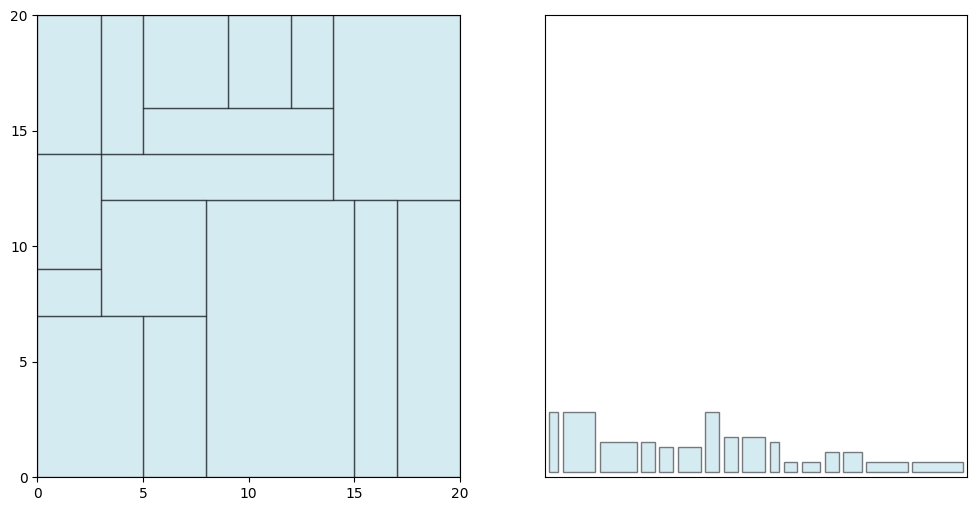

In [23]:
main()

## Genetic algorithms - ChatGPT implementation with Inspyred library

**NEED**
- configuration to represent an individual(solution)
- Mutation function
- Crossover function
- Selection
- Fitness function

In [2]:
import inspyred
import random

In [3]:
# Define the fixed-size bin dimensions
bin_width = 20
bin_height = 20

# Define the list of objects with their dimensions
objects = [(2, 3), (4, 2), (3, 3), (1, 4), (5, 1)]

placements = [(0,0), (0,10), (10,0), (10,10)]

In [4]:
# Define the evaluation function to maximize the number of objects in the bin
def evaluate(candidate, args):
    bin_width, bin_height, objects = args
    bin_area = bin_width * bin_height
    total_area = 0

    # Check for collisions between objects
    for i in range(len(candidate)):
        for j in range(i + 1, len(candidate)):
            if candidate[i][0] > 0 and candidate[j][0] > 0:
                x1, y1, w1, h1 = candidate[i]
                x2, y2, w2, h2 = candidate[j]

                if not (x1 + w1 <= x2 or x2 + w2 <= x1 or y1 + h1 <= y2 or y2 + h2 <= y1):
                    return 0  # Collision detected, invalid solution

    for obj in candidate:
        total_area += obj[2] * obj[3]

    return bin_area - total_area

# Define the genetic algorithm using Inspyred
def genetic_algorithm(prng, evaluator, args):
    ea = inspyred.ec.ES(prng)
    ea.variator = [inspyred.ec.variators.uniform_crossover,
                   inspyred.ec.variators.gaussian_mutation]
    ea.selector = inspyred.ec.selectors.tournament_selection
    ea.replacer = inspyred.ec.replacers.steady_state_replacement

    final_pop = ea.evolve(generator=generate,
                         evaluator=evaluator,
                         maximize=True,
                         pop_size=100,
                         max_generations=100,
                         crossover_rate=0.7,
                         mutation_rate=0.2,
                         num_selected=50,
                         bounder=inspyred.ec.Bounder(0, 1),
                         args=args)

    return max(final_pop)

# Define the generator function to create candidate solutions
def generate(random, args):
    bin_width, bin_height, objects = args
    candidate = []

    for obj in objects:
        # Each object has x, y, width, height as decision variables
        x = random.uniform(0, bin_width - obj[0])
        y = random.uniform(0, bin_height - obj[1])
        candidate.append((x, y, obj[0], obj[1]))

    return candidate

In [6]:
# Set up the optimization problem
#problem = inspyred.benchmarks.BinPacking(bin_width, bin_height, objects)

# Run the genetic algorithm
best_solution = genetic_algorithm(random.Random(), evaluate, (bin_width, bin_height, objects))

# Display the results
print("Best Solution:")
print("Objects included:", [obj for obj in best_solution.candidate if obj[2] > 0])
print("Remaining space in the bin:", evaluate(best_solution.candidate, (bin_width, bin_height, objects)))

ValueError: too many values to unpack (expected 3)

## Genetic algorithms from scratch

In [24]:
from typing import List, Callable, Tuple
from random import choices, randint, randrange, random
from functools import partial

BIN_WIDTH = 20
BIN_HEIGHT = 20

In [25]:
## utility functions
def get_overlap_area(pos_a, dim_a, pos_b, dim_b):
    pos_x_a, pos_y_a = pos_a[0], pos_a[1]
    width_a, height_a = dim_a[0], dim_a[1]
    pos_x_b, pos_y_b = pos_b[0], pos_b[1]
    width_b, height_b = dim_b[0], dim_b[1]

    overlap_x = max(0, min(pos_x_a + width_a, pos_x_b + width_b) - max(pos_x_a, pos_x_b))
    overlap_y = max(0, min(pos_y_a + height_a, pos_y_b + height_b) - max(pos_y_a, pos_y_b))

    overlap_area = overlap_x * overlap_y
    return overlap_area

def get_invalid_area(pos, dim):
    pos_x, pos_y = pos[0], pos[1]
    width, height = dim[0], dim[1]

    if ((pos_x + width) <= BIN_WIDTH) and ((pos_y + height) <= BIN_HEIGHT):
        return 0
    else:
        return (width*height) - get_overlap_area(pos, dim, (0,0), (BIN_WIDTH, BIN_HEIGHT))

In [31]:
## Genetic representation of a solution
Genome = List[Tuple[int, int]]
Population = List[Genome]
FitnessFunc = Callable[[Genome], int]
PopulateFunc = Callable[[], Population]
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Genome, Genome]]
CrossoverFunc = Callable[[Genome, Genome], Tuple[Genome, Genome]]
MutationFunc = Callable[[Genome], Genome]

items = [(2,12),(7,12),(8,6),(3,6),(3,5),(5,5),(3,12),(3,7),(5,7),(2,6),(3,2),(4,2),(3,4),(4,4),(9,2),(11,2)]

#def generate_genome(length: int):
#    return choices([0,1], k=length)

def generate_genome(items):
    candidate = []

    for obj in items:
        # Each object has x, y, width, height as decision variables
        x = randint(0, BIN_WIDTH - obj[0])
        y = randint(0, BIN_HEIGHT - obj[1])
        candidate.append((x, y))
    return candidate

def generate_population(size: int, items):
    return [generate_genome(items) for _ in range(size)]

def fitness(genome : Genome, items): 
    
    overlapped_area = 0

    for i in range(len(items)):
        for j in range(len(i, items)):
            overlapped_area += get_overlap_area(genome[i],items[i], genome[j],items[j]) ## Penalty for overlap
        overlapped_area += get_invalid_area(genome[i],items[i]) ## Penalty for invalid positions
    return overlapped_area    


def selection_pair(population: Population, fitness_func : FitnessFunc, n_parents : int = 2):
    return choices(population=population,
                   weights=[fitness_func(genome) for genome in population],
                   k=n_parents)

def single_point_crossover(a: Genome, b: Genome):
    assert len(a) == len(b), 'Genomes must have the same length'

    length = len(a)
    if length < 2:
        return a, b
    
    p = randint(1, length - 1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

def mutation(genome: Genome, items, num: int = 1, probability: float = 0.5):
    for _ in range(num):
        index = randrange(len(genome))
        if random() <= probability:
            x = randint(0, BIN_WIDTH - items[index][0])
            y = randint(0, BIN_HEIGHT - items[index][1])
            genome[index] = (x, y)
    return genome

def run_evolution(populate_func: PopulateFunc,
                  fitness_func: FitnessFunc,
                  fitness_limit: int = 0,
                  selection_func: SelectionFunc = selection_pair,
                  crossover_func: CrossoverFunc = single_point_crossover,
                  mutation_func: MutationFunc = mutation,
                  generation_limit: int = 100):
    
    population = populate_func()

    for i in range(generation_limit):
        population = sorted(population,
                            key=lambda genome: fitness_func(genome, items),
                            reverse=False)
        
        if fitness_func(population[0], items) == fitness_limit:
            break
        
        next_generation = population[0:2] ## Elitism

        for j in range(int(len(population) /2) - 1):
            parents = selection_func(population, fitness_func)
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])
            offspring_a = mutation_func(offspring_a, items)
            offspring_b = mutation_func(offspring_b, items)
            next_generation += [offspring_a, offspring_b]
        
        population = next_generation

    population = sorted(population,
                        key=lambda genome: fitness_func(genome),
                        reverse=False)
    
    return population, i

In [32]:
population, generations = run_evolution(
    populate_func=partial(generate_population, size=10, items=items),
    fitness_func=partial(fitness, items=items),
    generation_limit=100
)

print('number of generations: ', generations)
print('best solution: ', population[0])

TypeError: fitness() got multiple values for argument 'items'